In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [212]:
# Read Original Data
df = pd.read_csv("Data/diabetes.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Data Exploration

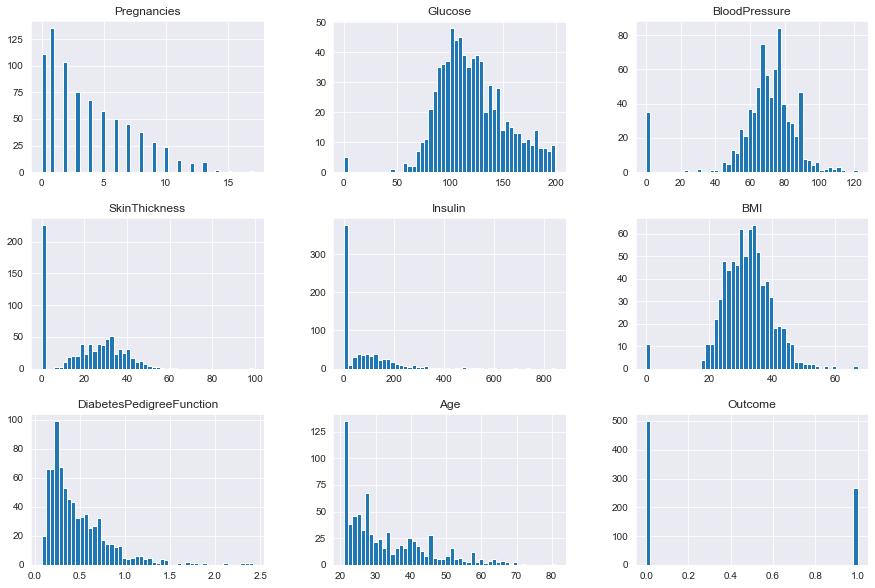

In [213]:
# Visualizing data distribution for each feature
df.hist(bins=50, figsize=(15, 10))
plt.show()

## Data Cleaning

In [214]:
df[(df.Glucose==0)|(df.BloodPressure==0)|(df.SkinThickness==0)|(df.Insulin==0)|(df.BMI==0)].count()

Pregnancies                 376
Glucose                     376
BloodPressure               376
SkinThickness               376
Insulin                     376
BMI                         376
DiabetesPedigreeFunction    376
Age                         376
Outcome                     376
dtype: int64

In [193]:
# drop SkinThickness == 0
df = df[df['SkinThickness'] != 0]

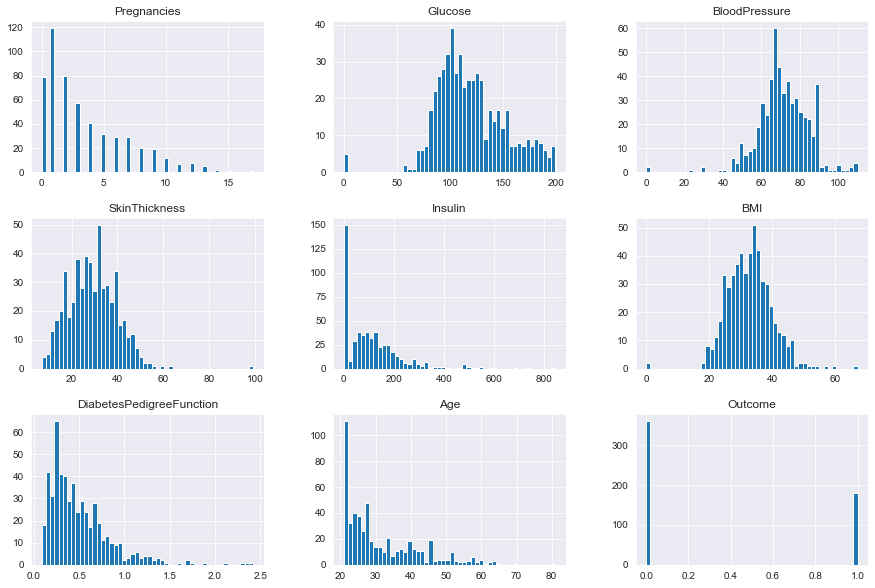

In [194]:
# Visualizing data distribution for each feature
df.hist(bins=50, figsize=(15, 10))
plt.show()

In [195]:
from scipy import stats

# Compute z-scores for each column
z = np.abs(stats.zscore(df))

# Define a threshold for outlier detection
threshold = 3

# Remove rows with at least one outlier
df = df[(z < threshold).all(axis=1)]

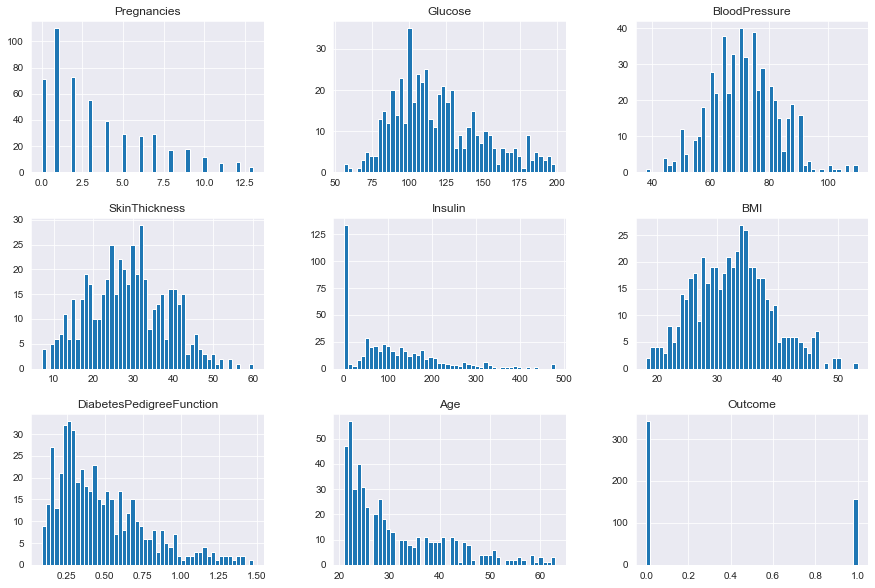

In [196]:
# Visualizing data distribution for each feature
df.hist(bins=50, figsize=(15, 10))
plt.show()

In [197]:
# 1. BMI Categories
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, np.inf], labels=[0, 1, 2, 3])

# 2. Insulin Level Categories
df['Insulin_Category'] = pd.cut(df['Insulin'], bins=[-1, 0, 25, 100, np.inf], labels=[0, 1, 2, 3])

# 3. Age Group
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 12, 18, 30, 50, np.inf], labels=[0, 1, 2, 3, 4])

# 4. Medical Risk
df['Medical_Risk'] = df['Age'] * df['BMI'] * df['BloodPressure'] / 1000

# 5. Diabetes Risk
df['Diabetes_Risk'] = df['Medical_Risk'] / (df['DiabetesPedigreeFunction'] * 100)

# 6. Ratio of Variables
df['Insulin_to_Glucose_Ratio'] = df['Insulin'] / df['Glucose']
df['BMI_to_BloodPressure_Ratio'] = df['BMI'] / df['BloodPressure']

# 7. Polynomial Features
df['BMI_Squared'] = df['BMI'] ** 2
df['Glucose_Squared'] = df['Glucose'] ** 2

# Display the modified dataset
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category,Insulin_Category,Age_Group,Medical_Risk,Diabetes_Risk,Insulin_to_Glucose_Ratio,BMI_to_BloodPressure_Ratio,BMI_Squared,Glucose_Squared
0,6,148,72,35,0,33.6,0.627,50,1,3,0,3,120.9600,1.929187,0.000000,0.466667,1128.96,21904
1,1,85,66,29,0,26.6,0.351,31,0,2,0,3,54.4236,1.550530,0.000000,0.403030,707.56,7225
3,1,89,66,23,94,28.1,0.167,21,0,2,2,2,38.9466,2.332132,1.056180,0.425758,789.61,7921
6,3,78,50,32,88,31.0,0.248,26,1,3,2,2,40.3000,1.625000,1.128205,0.620000,961.00,6084
14,5,166,72,19,175,25.8,0.587,51,1,2,3,4,94.7376,1.613928,1.054217,0.358333,665.64,27556


In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 767
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Pregnancies                 500 non-null    int64   
 1   Glucose                     500 non-null    int64   
 2   BloodPressure               500 non-null    int64   
 3   SkinThickness               500 non-null    int64   
 4   Insulin                     500 non-null    int64   
 5   BMI                         500 non-null    float64 
 6   DiabetesPedigreeFunction    500 non-null    float64 
 7   Age                         500 non-null    int64   
 8   Outcome                     500 non-null    int64   
 9   BMI_Category                500 non-null    category
 10  Insulin_Category            500 non-null    category
 11  Age_Group                   500 non-null    category
 12  Medical_Risk                500 non-null    float64 
 13  Diabetes_Risk       

In [206]:
# Split the data into features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

K_NUMBER = 10

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. Univariate Feature Selection with SelectKBest
selector = SelectKBest(mutual_info_classif, k=K_NUMBER)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# 2. Recursive Feature Elimination with Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
X_train_rf = X_train.iloc[:, indices[:K_NUMBER]]
X_test_rf = X_test.iloc[:, indices[:K_NUMBER]]

# 3. SelectFromModel with Random Forest
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(estimator=RandomForestClassifier(), max_features=K_NUMBER)
X_train_sfm = selector.fit_transform(X_train, y_train)
X_test_sfm = selector.transform(X_test)

# Print the selected features for each method
print("Univariate Feature Selection with SelectKBest")
print(X_train.columns[selector.get_support()])

print("\nRecursive Feature Elimination with Random Forest")
print(X_train_rf.columns)

print("\nSelectFromModel with Random Forest")
print(pd.DataFrame(X_train_sfm, columns=X_train.columns[selector.get_support()]).columns)

Univariate Feature Selection with SelectKBest
Index(['Glucose', 'Insulin', 'DiabetesPedigreeFunction', 'Age', 'Medical_Risk',
       'Glucose_Squared'],
      dtype='object')

Recursive Feature Elimination with Random Forest
Index(['Glucose_Squared', 'Glucose', 'Medical_Risk', 'Age',
       'DiabetesPedigreeFunction', 'BMI', 'Diabetes_Risk', 'Insulin',
       'BMI_to_BloodPressure_Ratio', 'Insulin_to_Glucose_Ratio'],
      dtype='object')

SelectFromModel with Random Forest
Index(['Glucose', 'Insulin', 'DiabetesPedigreeFunction', 'Age', 'Medical_Risk',
       'Glucose_Squared'],
      dtype='object')


In [207]:
df_best = df[['Glucose_Squared', 'Glucose', 'Medical_Risk', 'Age',
       'DiabetesPedigreeFunction', 'BMI', 'Diabetes_Risk', 'Insulin',
       'BMI_to_BloodPressure_Ratio', 'Insulin_to_Glucose_Ratio', 'Outcome']].copy()

<AxesSubplot: title={'center': 'Correlation'}>

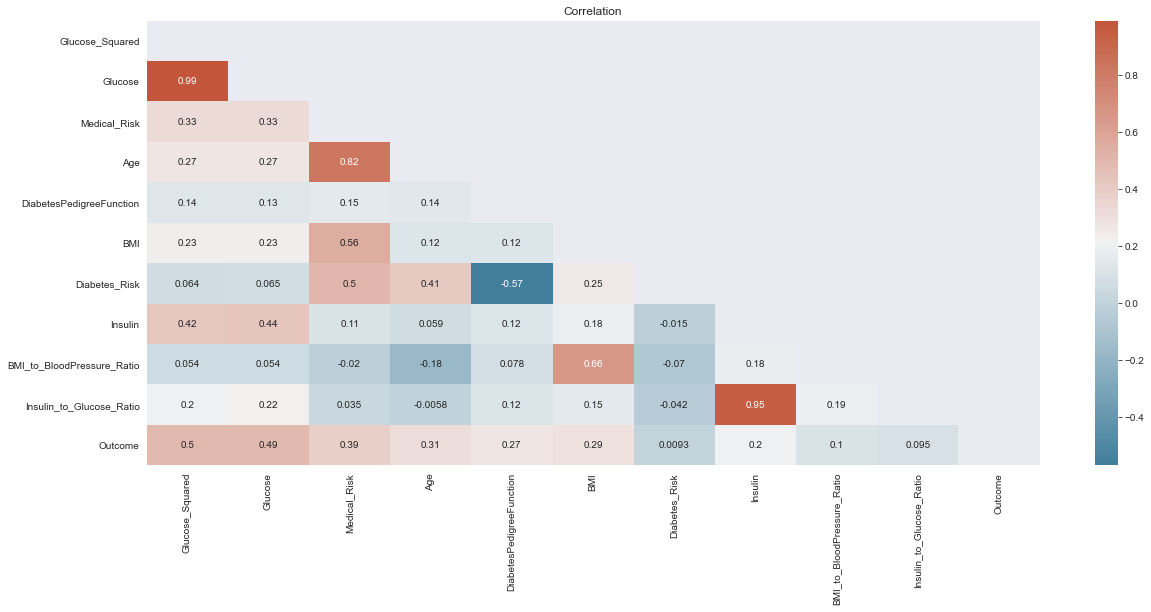

In [209]:
corr = df_best.corr()

# Set up the matplotlib plot configuration
plt.figure(figsize=(20,18))

plt.subplot(2,1,1)

# Generate a mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
plt.title('Correlation')
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [211]:
df_best = df_best.drop(columns=["Glucose_Squared", "Age", "Insulin_to_Glucose_Ratio"])

In [ ]:
df_best.to_csv("Data/diabetes_processed.csv", index=False)